Electrocardiography is the process of producing an electrocardiogram (ECG or EKG), a recording of the heart's electrical activity through repeated cardiac cycles. It is an electrogram of the heart which is a graph of voltage versus time of the electrical activity of the heart using electrodes placed on the skin. These electrodes detect the small electrical changes that are a consequence of cardiac muscle depolarization followed by repolarization during each cardiac cycle (heartbeat).

In [ ]:
<img src=""/>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/EKG_Complex_en.svg/581px-EKG_Complex_en.svg.png" alt="File:EKG Complex en.svg"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Animation_of_ECG_Limb_Leads.gif/530px-Animation_of_ECG_Limb_Leads.gif" width="600"/>

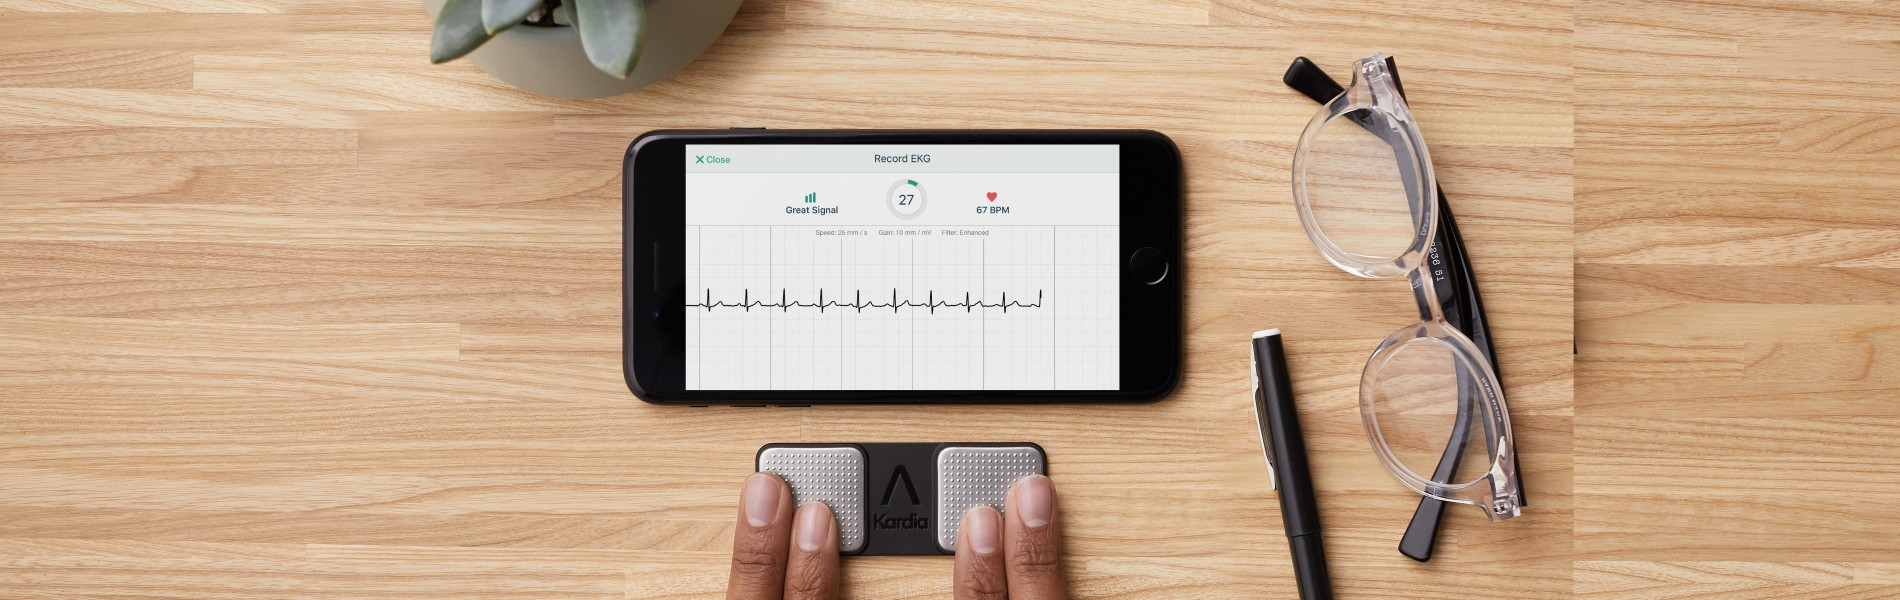

In [2]:
#----------------------------------------------------------------------#
# 1) DOWNLOAD PHYSIONET2017 DATA:
#
# wget -r -N -c -np https://physionet.org/files/challenge-2017/1.0.0/

#FINISHED --2024-04-03 17:14:22--
#Total wall clock time: 59m 12s
#Downloaded: 17781 files, 1.5G in 40m 15s (669 KB/s)

# unzip training2017.zip

# (Really only using: .../1.0.0/training2017.zip + .../1.0.0/REFERENCE-v3.csv?)

# afib_cohort_with_matching_waveform.csv
#
# unzip afibdataset.zip
# mv afibdataset MIT_AFib_Dataset
# rm *WFDB.csv
#
#----------------------------------------------------------------------#

#----------------------------------------------------------------------#
# 2) CONDA ENV. SETUP (Assuming base Conda. Env.)
#
# export MY_ENV_NAME=B2AI
# conda create --name $MY_ENV_NAME python=3.11
# conda activate $MY_ENV_NAME
#
# conda install ipykernel
# python -m ipykernel install --user --name $MY_ENV_NAME --display-name "$MY_ENV_NAME (Py3.11)"
#----------------------------------------------------------------------#

#----------------------------------------------------------------------#
# 3) INSTALL DEPENDENCIES:
# 
# conda install scipy scikit-learn catboost matplotlib pandas pywavelets statsmodels
# conda install -c conda-forge librosa mne tsfresh
#
# MAIN LIBS:
# scipy
# sklearn
# catboost
#
# UTIL. LIBS:
# matplotlib
# pandas
# librosa
# mne
# pywt
# statsmodels
#----------------------------------------------------------------------#

In [3]:
# Import utils. for OS interaction, timing, serialization.
import os
import time
import pickle

# Import Numerical Python & Pandas, for dataframe work.
import numpy as np
import pandas as pd

# Import the I/O module from Scientific Python package.
import scipy.io

# Import metric-based utils. from SciKit-Learn pacakge.
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Import plotting libs.
import matplotlib.pyplot as plt
import seaborn as sns

# Import the classifier class from our chosed gradient-boosted tree model lib.
from catboost import CatBoostClassifier

# Import the 'Time Series Feature extraction based on scalable hypothesis tests' feature selection sub-module.
from tsfresh import select_features

# Be a bit naughty and import all of our functions from the CHoRUS Utils. python file.
from CHoRUS_Utilities import *

/home/agent3/miniconda3/envs/B2AI/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
# All PhysioNet2017 data is at 300Hz sampling frequency, set this as a global.
fs = 300 

In [5]:
# Specify the folder path containing the .mat files. We're using the data in the unzipped 'training2017.zip'.
folder_path = 'training2017/'

In [6]:
# Annotation file name. NB: v3 should be the most up to date, and is the same as the ./training/REFERENCE-v3.csv
anno_file_v3 = 'REFERENCE-v3.csv'

# load the annotations
annotations = load_annotations(f'{folder_path}/../{anno_file_v3}')

In [7]:
# Target Labels/Classes:

#     Normal = N = 0
#     AFib   = A = 1
#     Other  = O = 2
#     Noisy  = ~ = 3

annotations

,Record,Label,Class
0,A00001,N,0
1,A00002,N,0
2,A00003,N,0
3,A00004,A,1
4,A00005,A,1
...,...,...,...
8523,A08524,N,0
8524,A08525,O,2
8525,A08526,N,0
8526,A08527,N,0


Note: Rather than a binary classification task (AFib vs. No-AFib) the problem is posed with two other class options; 'Noisy' & 'Other'. It's likely that the Noisy class look similar in some way, but we're also giving another class, here 'Other', for the model to say, 'Hmm I'm not sure about this sample. Ah, I guess I'll just put it in the 'Other' class bin.

In [8]:
# Visualizations

In [9]:
def plot_record_data(folder_path, label):
    # Make a list of all the 'Normal' records.
    normal_records = annotations[annotations['Label']==label]['Record'].values
    
    # Which record would be like to look at?
    test_record = normal_records[0]
    
    # Load the ECG signal data.
    ecg_signal = read_waveform(folder_path, test_record)

    # Print the record number and the corresponding label.
    label_dict = {'N': 'Normal', 'A': 'AFib', 'O': 'Other', '~': 'Noisy'}
    print(f'Record: {test_record}, Label: {label_dict[label]}')

    # Break the record into 10-second chunks and run R-detection and plot.
    #for i in range(int(len(ecg_signal)/fs/10)):
    #    r_detection(ecg_signal[i*fs*10:(i+1)*fs*10], fs, wd=5, plot=True, preprocess=True)

    r_detection(ecg_signal, fs, wd=5, plot=True, preprocess=True)

In [ ]:
plot_record_data(folder_path, 'N')

In [ ]:
plot_record_data(folder_path, 'A')

In [ ]:
plot_record_data(folder_path, 'O')

In [ ]:
plot_record_data(folder_path, '~')

In [ ]:
# Feature Extraction: This takes about an hour on a single core.

# Setup empty arrays to hold the extracted features and the associated labels.
features = np.zeros((len(annotations), 97))
labels = np.zeros((len(annotations), 1))

# Instantiate timer.
start_time = time.time()

# Loop over the records in the annotations df.
for iter1 in range(len(annotations)):
    # Get the record name and append the '.mat' suffix.
    record = annotations['Record'].iloc[iter1]
    
    # Get the corresponding label.
    label = annotations['Int_Label'].iloc[iter1]
    
    # Load the WF data from record.
    data = read_waveform(folder_path, record)
    
    # Print the progress counter and file/label information.
    print(f"[INFO:] {iter1+1}/{len(annotations)}, Loaded data: {record}, label: {annotations['Raw_Label'].iloc[iter1]}", end="\r") 
    
    # Extract the features from the WF sample. Add the features and label to the relevant matrices.
    features[iter1, :] = feature_extraction(data, fs)
    labels[iter1] = label

# End the timer and print the feature extraction time.
end_time = time.time()
time_spent = end_time - start_time
print(f"[INFO:] Time spent for feature extraction: {time_spent/60:.2f} min")

# Save the features and labels
with open('Derived_Data/features.pkl', 'wb') as save_file:
    pickle.dump(features, save_file)

with open('Derived_Data/labels.pkl', 'wb') as save_file:
    pickle.dump(labels, save_file)

print(f"[INFO:] Extracted features and labels are saved!")
print(f"[INFO:] Shape of extracted feature matrix: {features.shape}")
print(f"[INFO:] Shape of label vector: {labels.shape}")

In [10]:
# Extracted Features:

97 features are extracted from various domains within each ECG waveform. 
These features quantify signal characteristics across time, frequency, time-frequency, and nonlinear domains.

1st set of features: beat_features_v0

The function calculates various statistical features from different segments of each beat around the R-peaks. 
These features are related to the P-wave, QRS-complex, QT interval, and ST-segment of the ECG signal.

For each R-peak, it extracts segments of the ECG signal corresponding to different parts of the cardiac cycle: P-wave, QRS complex, QT interval, and ST segment. 
For each segment, it calculates statistical features, including PAR (positive area ratio), NAR (negative area ratio), 
md (mean of the first derivative), vd (variance of the first derivative), and PP (peak-to-peak amplitude).

In [11]:
beat_features_v0 = ['P_PAR', 'QRS_PAR', 'QT_PAR', 'ST_PAR', 
                    'P_NAR', 'QRS_NAR', 'QT_NAR', 'ST_NAR',
                    'P_md',  'QRS_md',  'QT_md',  'ST_md',
                    'P_vd',  'QRS_vd',  'QT_vd',  'ST_vd',
                    'P_PP',  'QRS_PP',  'QT_PP',  'ST_PP'] 

2nd set of features: beat_features_v1

Below is a breakdown of the function's operations:

1. Input Validation: The function checks if the length of the input beats is greater than 3. If not, it returns an array of zeros.

2. Interpolation: If there are more than 3 beats, the function interpolates each beat to 201 samples.
3. This is done through a helper function interpolate_to_201_samples, which interpolates the beats to make them of equal length for further analysis.

4. Cosine Similarity: The function calculates the cosine similarity for each pair of beats.
5. It iterates over all possible pairs of beats and computes the cosine similarity between their corresponding interpolated samples.
6. These similarities are stored in a list.

a. Statistical Analysis: The function computes the mean and variance of cosine similarities and the mean and variance of average periods.

4. Autocorrelation and Average Period: The function calculates autocorrelation and the average period for each pair of beats.
5. Autocorrelation measures how similar a signal is to a delayed version of itself.
6. The function finds peaks in the autocorrelation function and calculates the average period based on these peaks.

7. Eigenvalues Analysis: It computes the covariance matrix of the interpolated beats and then calculates the eigenvalues of this covariance matrix.
8. Percentiles of the eigenvalues are computed to capture the distributional properties of these values.

9. Zero Crossings: It identifies zero crossings in the sum of all interpolated beats (mbeats).
10. If there are more than 4 zero crossings, it calculates the interquartile range (IQR) of the differences between consecutive zero crossings.

11. Gradient Analysis: It computes the gradient of the sum of all interpolated beats (mbeats) and then the second gradient.
12. Then, it calculates several statistics related to the variance of these gradients.

13. Entropy Calculation: It computes the Shannon entropy of the distribution of amplitudes in the sum of all interpolated beats.

In [12]:
beat_features_v1 = ['cos_mean', 'cos_var', 'corr_mean', 'corr_var',
                    'zero_crossings', 
                    'beats_var', 'beats_diff_1', 'beats_diff_2', 
                    'shannon_entropy', 
                    'eigstats_25', 'eigstats_50', 'eigstats_75', 'eigstats_99']

3rd set of features: advanced_features

Below is a breakdown of the function's operations:

1. Wavelet Transform decomposes the input signal using the Discrete Wavelet Transform (pywt.wavedec). The decomposition is done with a level of 5 using the Daubechies 4 (db4) wavelet.
    a. It computes Waveform Entropy (TWE).

2. Zero Crossings: It calculates the interquartile range (IQR) of the differences between consecutive zero crossings in the input signal.

4. Autocorrelation: It calculates the autocorrelation of the input signal and finds the average period from the autocorrelation peaks.

3. Gradient Analysis: It computes various statistics related to the gradient of the input signal.

8. Spectrogram Analysis: It computes the spectrogram of the input signal and extracts various statistics from it.

9. Instantaneous Frequency: It computes the instantaneous frequency using the Hilbert transform.

5. Power Spectral Density (PSD): It computes the PSD of the input signal using the Welch method (signal.welch).
    a. Power Band Features: It calculates maximum and mean power in different frequency bands.

10. Seasonal Autocorrelation: It calculates seasonal autocorrelation at different time lags.

11. Entropy: It computes the Shannon entropy of the input signal.

12. Hjorth Parameters: It calculates Hjorth parameters: mobility (pfd) and complexity (kfd).

13. Coefficient Distribution Homogeneity: It calculates the homogeneity of the distribution of continuous wavelet transform coefficients.

6. Spectral Edge Frequency: It calculates the spectral edge frequency at different percentage levels.

7. Burg Autoregression Coefficients: It computes the Burg AR coefficients.

In [13]:
advanced_features = ['wf_entropy', 
                     'adv_zero_crossings', 
                     'grad_var', 'grad_1', 'grad_2', 
                     'CWT_coeff_5_var', 'CWT_coeff_4_var', 'CWT_coeff_3_var', 
                     'mean_period', 
                     'psd_ent', 
                     'spectrogram_max', 'spectrogram_var',
                     'inst_freq_mean', 'inst_freq_std', 
                     'psd_low', 'psd_med', 'psd_high', 
                     'seas_auto_1', 'seas_auto_2', 'seas_auto_3',
                     'adv_shannon_entropy', 
                     'Hjorth_mobility', 'Hjorth_complexity', 
                     'CWT_homogeneity', 
                     'spectral_edge_freq_50', 'spectral_edge_freq_70', 'spectral_edge_freq_80', 
                     'spectral_edge_freq_90', 'spectral_edge_freq_95',
                     'Burg_AR_coeff_1', 'Burg_AR_coeff_2', 'Burg_AR_coeff_3',
                     'Burg_AR_coeff_4', 'Burg_AR_coeff_5', 'Burg_AR_coeff_6',
                     'Burg_AR_coeff_7', 'Burg_AR_coeff_8', 'Burg_AR_coeff_9',
                     'Burg_AR_coeff_10'] 

4th set of features: sh_vs_nshself

Below is a breakdown of the function's operations:

1. Bandpass Filtering: It applies a bandpass Butterworth filter to the input signal to extract the frequency components within a specific range, typically representing the heart rate.

2. Amplitude Variation (f1): It calculates the peak-to-peak amplitude of the filtered signal as a measure of amplitude variation.

3. Proportion of Time Below Threshold (f2): It computes the proportion of time the squared first difference of the input signal is below a threshold (ThS). This measure provides insight into the regularity of the signal.

4. Frequency Domain Analysis (f3): It performs a frequency domain analysis using the Fourier transform. It calculates the power spectrum of the input signal. It normalizes the power spectrum. It calculates the cumulative sum of the normalized spectrum. It finds the frequencies below and above which a certain proportion of power is contained (power_proportion). These frequencies represent the bandwidth of the signal.

In [14]:
shfeatures = ['filt_spec_f1', 'filt_spec_f2', 'filt_spec_f3'] 

5th set of features: hrv_features

This function computes a variety of Heart Rate Variability (HRV) features from the input RR intervals. Here's a breakdown of what each part does:

1. NNx: The number of RR intervals differing by more than 50 ms.

2. pNNx: The percentage of RR intervals differing by more than 50 ms.

3. SD1: Standard deviation of beat-to-beat (NN) intervals in the Poincaré plot perpendicular to the identity line.

4. SD2: Standard deviation of beat-to-beat (NN) intervals in the Poincaré plot along the line of identity.

5. ratio_sd2_sd1: Ratio of SD2 to SD1.

6. CSI (Cardiac Sympathetic Index): The ratio of the long-term variation (L) to short-term variation (T) in the NN intervals.

7. CVI (Cardiac Vagal Index): A logarithmic transformation of the product of L and T.

8. modifiedCVI: Modified CVI.

9. f1: Root Mean Square of Successive Differences (RMSSD).

10. f2: The ratio of the mean and standard deviation of NN intervals.

11. sk_RR: Skewness of NN intervals.

12. kurt_RR: Kurtosis of NN intervals.

13. sampen_value: Sample entropy value.

14. Features related to polynomial fit coefficients and geometric features: These include characteristics derived from polynomial fitting and geometric properties of the RR interval scatter plot.

In [15]:
hrv_features = ['NNx', 'pNNx', 'SD1', 'SD2', 'ratio_sd2_sd1', 'CSI', 'CVI', 
                'CVI_mod', 'RMSSD', 'f2', 'sk_RR', 'kurt_RR', 'sampen_value',
                'p_coeff_2', 'p_coeff_5', 'p_coeff_6', 'p_coeff_7', 
                'p_coeff_OU', 'p_coeff_OO', 'p_coeff_OD', 
                'p_coeff_DU', 'p_coeff_DD'] 

In [16]:
# Combin all the feature names in a total list of feature names
feature_names = beat_features_v0 + beat_features_v1 + advanced_features + shfeatures + hrv_features
print(f'We have a total of {len(feature_names)} features.')

We have a total of 97 features.


In [17]:
# Load the derived features.

In [18]:
# Load the features and labels
with open('Derived_Data/features.pkl', 'rb') as load_file:
    features = pickle.load(load_file)
    
with open('Derived_Data/labels.pkl', 'rb') as load_file:
    labels = pickle.load(load_file)

print(f"[INFO:] Extracted features and labels are loaded!")
print(f"[INFO:] Shape of loaded feature matrix: {features.shape}")
print(f"[INFO:] Shape of label vector: {labels.shape}")

[INFO:] Extracted features and labels are loaded!
[INFO:] Shape of loaded feature matrix: (8528, 97)
[INFO:] Shape of label vector: (8528, 1)


In [19]:
# Loop through the data to get the length (number of samples) that comprise each signal.
data_lengths = []

# Loop over the records in the annotations df.
for iter1 in range(len(annotations)):
    
    # Get the record name and append the '.mat' suffix.
    record = annotations['Record'].iloc[iter1]

    # Load the WF data from record.
    data = read_waveform(folder_path, record)
    
    data_lengths.append(len(data))

# Add the length of each sample to the annotations dataframe.
annotations['Sample Length'] = data_lengths

In [20]:
annotations

,Record,Label,Class,Sample Length
0,A00001,N,0,9000
1,A00002,N,0,9000
2,A00003,N,0,18000
3,A00004,A,1,9000
4,A00005,A,1,18000
...,...,...,...,...
8523,A08524,N,0,9000
8524,A08525,O,2,9000
8525,A08526,N,0,10904
8526,A08527,N,0,9000


In [21]:
# Iterate over the new column names and assign data from the numpy array.
for i, feature_name in enumerate(feature_names):
    annotations[feature_name] = features[:, i]

In [22]:
annotations

,Record,Label,Class,Sample Length,P_PAR,QRS_PAR,QT_PAR,ST_PAR,P_NAR,QRS_NAR,...,sampen_value,p_coeff_2,p_coeff_5,p_coeff_6,p_coeff_7,p_coeff_OU,p_coeff_OO,p_coeff_OD,p_coeff_DU,p_coeff_DD
0,A00001,N,0,9000,0.075190,0.100303,0.457231,0.000000,0.116479,0.084388,...,0.639801,0.611919,2.376207,-0.060468,-0.161982,0.0,9.0,9.0,1.0,8.0
1,A00002,N,0,9000,0.196360,0.413719,0.552415,0.000000,0.363274,0.336582,...,0.798508,0.771558,2.453826,-0.247281,-0.821940,0.0,7.0,10.0,0.0,3.0
2,A00003,N,0,18000,0.201028,0.190515,0.344653,0.335586,0.111540,0.145595,...,0.836010,0.568720,2.603220,-0.235777,-0.650838,2.0,18.0,16.0,0.0,21.0
3,A00004,A,1,9000,0.000000,0.218785,0.069993,0.000000,0.239454,0.159237,...,38.123095,0.888053,1.521822,-0.088023,-0.734966,0.0,8.0,8.0,0.0,4.0
4,A00005,A,1,18000,0.131674,0.327784,0.433331,0.000000,0.219253,0.220187,...,1.216395,0.487836,2.608317,-0.233029,-0.637354,3.0,13.0,22.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,A08524,N,0,9000,0.120336,0.166728,0.047880,0.000000,0.251193,0.164632,...,1.386294,0.748837,0.215648,-0.001961,-0.847740,0.0,9.0,8.0,0.0,7.0
8524,A08525,O,2,9000,0.250188,0.021319,0.438306,0.253244,0.116847,0.305980,...,0.466374,0.631237,2.149791,-0.074542,-0.255559,0.0,2.0,16.0,1.0,1.0
8525,A08526,N,0,10904,0.099514,0.168446,0.070577,0.000000,0.191836,0.208260,...,1.481605,0.674141,0.714772,-0.021841,-0.862481,1.0,15.0,6.0,1.0,12.0
8526,A08527,N,0,9000,0.274068,0.314272,0.000000,0.018197,0.365778,0.440956,...,0.653027,0.396991,2.663955,-0.272683,-0.743370,0.0,12.0,13.0,0.0,6.0


In [23]:
# Take a look at the counts of signal lengths.
annotations['Sample Length'].value_counts()

Sample Length
9000     5977
18000     809
4174        4
5364        4
4072        4
         ... 
14152       1
7684        1
3926        1
16946       1
10904       1
Name: count, Length: 1487, dtype: int64

In [ ]:
# Take a look at the distribution of signal lengths.
annotations['Sample Length'].hist()

In [24]:
# Select rows (confusingly also called 'samples') from the df that have signal length of 30 seconds.
annotations_30s = annotations[annotations['Sample Length']==fs*30]

In [25]:
annotations_30s

,Record,Label,Class,Sample Length,P_PAR,QRS_PAR,QT_PAR,ST_PAR,P_NAR,QRS_NAR,...,sampen_value,p_coeff_2,p_coeff_5,p_coeff_6,p_coeff_7,p_coeff_OU,p_coeff_OO,p_coeff_OD,p_coeff_DU,p_coeff_DD
0,A00001,N,0,9000,0.075190,0.100303,0.457231,0.000000,0.116479,0.084388,...,0.639801,0.611919,2.376207,-0.060468,-0.161982,0.0,9.0,9.0,1.0,8.0
1,A00002,N,0,9000,0.196360,0.413719,0.552415,0.000000,0.363274,0.336582,...,0.798508,0.771558,2.453826,-0.247281,-0.821940,0.0,7.0,10.0,0.0,3.0
3,A00004,A,1,9000,0.000000,0.218785,0.069993,0.000000,0.239454,0.159237,...,38.123095,0.888053,1.521822,-0.088023,-0.734966,0.0,8.0,8.0,0.0,4.0
5,A00006,N,0,9000,0.176864,0.321616,0.188372,0.402219,0.157097,0.221943,...,0.998529,1.057824,0.753075,-0.015762,-0.487827,0.0,8.0,6.0,1.0,5.0
6,A00007,N,0,9000,0.297181,0.403726,0.164998,0.460922,0.133419,0.198383,...,2.197225,0.917125,0.450540,-0.008508,-0.839132,1.0,7.0,3.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8522,A08523,A,1,9000,0.213300,0.203451,0.304016,0.386495,0.014673,0.193449,...,38.346238,0.757071,2.537459,-0.226302,-0.659388,0.0,4.0,12.0,1.0,3.0
8523,A08524,N,0,9000,0.120336,0.166728,0.047880,0.000000,0.251193,0.164632,...,1.386294,0.748837,0.215648,-0.001961,-0.847740,0.0,9.0,8.0,0.0,7.0
8524,A08525,O,2,9000,0.250188,0.021319,0.438306,0.253244,0.116847,0.305980,...,0.466374,0.631237,2.149791,-0.074542,-0.255559,0.0,2.0,16.0,1.0,1.0
8526,A08527,N,0,9000,0.274068,0.314272,0.000000,0.018197,0.365778,0.440956,...,0.653027,0.396991,2.663955,-0.272683,-0.743370,0.0,12.0,13.0,0.0,6.0


In [26]:
# Make sure that the distribution of labels still looks okay:

In [27]:
# Get the counts of classes in the total df.
annotations['Label'].value_counts()

Label
N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

In [ ]:
# Plot the histogram of classes in the total df.
annotations['Label'].hist()

In [28]:
# Get the counts of classes in the '30-second-samples' df.
annotations_30s['Label'].value_counts()

Label
N    3695
O    1655
A     504
~     123
Name: count, dtype: int64

In [ ]:
# Plot the histogram of classes in the '30-second-samples' df.
annotations_30s['Label'].hist()

In [29]:
# Correlation and Target Significance.

In [30]:
# Select features that are 'relevent' to the target vector:

# Kendall rank correlation coefficient used for features with real values and a target with real values. ('Real' is used here in the mathematical sense: they mean 'non-binary' feature/target.)
X_selected = select_features(annotations_30s[feature_names], annotations_30s['Class'], test_for_real_target_real_feature='kendall', fdr_level=0.05, multiclass=True, n_significant=4)
X_selected

,Burg_AR_coeff_1,Burg_AR_coeff_10,Burg_AR_coeff_2,CSI,CVI,CVI_mod,P_NAR,P_PAR,QRS_NAR,QRS_md,...,p_coeff_OD,p_coeff_OO,psd_med,ratio_sd2_sd1,sampen_value,seas_auto_2,spectral_edge_freq_80,spectral_edge_freq_90,spectral_edge_freq_95,spectrogram_max
0,0.000269,-0.000047,-0.000252,0.007979,6.243704,0.943505,0.116479,0.075190,0.084388,0.000216,...,9.0,9.0,0.195212,125.334829,0.639801,2.059713,11.5,15.0,18.0,1.464844
1,0.000262,-0.000046,-0.000240,0.015079,6.494502,3.271968,0.363274,0.196360,0.336582,0.000673,...,10.0,7.0,0.126245,66.317454,0.798508,0.428914,15.5,19.5,23.5,1.171875
3,0.000266,-0.000048,-0.000244,0.010205,6.363309,1.566224,0.239454,0.000000,0.159237,0.000603,...,8.0,8.0,0.161491,97.994178,38.123095,2.588982,12.5,16.5,20.0,4.101562
5,0.000263,-0.000048,-0.000240,0.004138,6.002063,0.266797,0.157097,0.176864,0.221943,0.000629,...,6.0,8.0,0.132862,241.675835,0.998529,-4.476067,14.0,17.5,20.5,2.343750
6,0.000262,-0.000053,-0.000234,0.003059,5.818783,0.137341,0.133419,0.297181,0.198383,0.000660,...,3.0,7.0,0.146032,326.883818,2.197225,-2.703432,14.5,17.5,20.0,3.515625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8522,0.000255,-0.000052,-0.000223,0.011851,6.432620,2.123012,0.014673,0.213300,0.193449,0.000638,...,12.0,4.0,0.107737,84.379790,38.346238,1.052418,17.5,21.5,25.0,1.171875
8523,0.000268,-0.000050,-0.000247,0.001616,5.538550,0.038190,0.251193,0.120336,0.164632,0.000292,...,8.0,9.0,0.187334,618.800153,1.386294,0.211416,11.5,14.5,17.5,1.171875
8524,0.000301,-0.000020,-0.000326,0.011350,6.416511,1.953134,0.116847,0.250188,0.305980,0.000258,...,16.0,2.0,0.685763,88.108061,0.466374,2.878471,6.0,8.0,9.5,2.636719
8526,0.000269,-0.000046,-0.000248,0.007663,6.224637,0.868859,0.365778,0.274068,0.440956,0.001218,...,13.0,12.0,0.189728,130.490704,0.653027,0.638442,9.0,13.0,17.5,2.050781


In [31]:
# Make a list of the selected features and see how many we have.
selected_features = X_selected.columns.to_list()
print(f'The new feature matrix has {len(selected_features)} retained features.')

The new feature matrix has 33 retained features.


In [32]:
# This will give you a matrix where each cell (i, j) represents the Pearson correlation coefficient between feature i and feature j.
correlation_matrix = X_selected.corr()

In [ ]:
# Plot the correlation matrix.
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix of Features")
plt.show()

In [33]:
# Cross-validation

In [34]:
# First, let's do 5-fold cross-validation:
n_folds = 5

# Define the label vector.
labels = annotations_30s['Class']

# Split the dataset into n_folds, preserving the ratio of the classes in each fold.
train_folds, test_folds = cross_validation(labels, n_folds=n_folds, random_state=42, method="skfold")

In [35]:
# Corresponding names of the target classes.
target_names = ['Normal', 'AFib', 'Other', 'Noisy']

In [36]:
# Set the dataframe to be used in the training.
data_df = annotations_30s

# Convert the features and labels from the dataframe back to numpy arrays (for some functional compatibility).

# We can either use all features, or just the ones that TSFresh selected earlier.
#features = data_df[feature_names].to_numpy()
features = data_df[selected_features].to_numpy()

# The labels are in the 'Class' column.
labels = data_df['Class'].to_numpy()

print(f"[INFO:] Final features and labels are configured!")
print(f"[INFO:] Shape of final feature matrix: {features.shape}")
print(f"[INFO:] Shape of label vector: {labels.shape}")

[INFO:] Final features and labels are configured!
[INFO:] Shape of final feature matrix: (5977, 33)
[INFO:] Shape of label vector: (5977,)


Overview of gradient boosting
To understand boosting, we must first understand ensemble learning, a set of techniques that combine the predictions from multiple models(weak learners) to get better predictive performance. Its strategy is simply strength in unity, as efficient combinations of weak learners can generate more accurate and robust models. The three main classes of ensemble learning methods are:

Bagging: This technique builds different models in parallel using random subsets of data and deterministically aggregates the predictions of all predictors.

Boosting: This technique is iterative, sequential, and adaptive as each predictor fixes its predecessor’s error.

Stacking: It is a meta-learning technique that involves combining predictions from multiple machine learning algorithms, like bagging and boosting.

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/When-to-Choose-CatBoost-Over-XGBoost-or-LightGBM-Practical-Guide_13.png?resize=771%2C431&amp;ssl=1" alt="The most popular boosting algorithms: Catboost, XGBoost, LightGBM"/>

Image Credit: Brian John, 'https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm'.

This technique involves training learners based upon minimizing the differential loss function of a weak learner using a gradient descent optimization process, in contrast to tweaking the weights of the training instances like Adaptive Boosting (Adaboost). Hence there is an equal distribution of weights to all the learners. Gradient boosting uses decision trees connected in series as weak learners. Due to its sequential architecture, it is a stage-wise additive model, where decision trees are added one at a time, and existing decision trees are not changed.  

Gradient boosting is primarily used to reduce the bias error of the model. Based on the bias-variance tradeoff, it is a greedy algorithm that can overfit a training dataset quickly. However, this overfitting can be controlled by shrinkage, tree constraint, regularization, and stochastic gradient boosting.

Gradient boosting
In gradient boosting, an ensemble of weak learners is used to improve the performance of a machine learning model. The weak learners are usually decision trees. Combined, their output results in better models. 

In case of regression, the final result is generated from the average of all weak learners. With classification, the final result can be computed as the class with the majority of votes from weak learners. 

In gradient boosting, weak learners work sequentially. Each model tries to improve on the error from the previous model. This is different from the bagging technique, where several models are fitted on subsets of the data in a parallel manner. These subsets are usually drawn randomly with replacement. A great example of bagging is in Random Forests. 

The boosting process looks like this:

Build an initial model with the data.

Run predictions on the whole data set.

Calculate the error using the predictions and the actual values.

Assign more weight to the incorrect predictions.

Create another model that attempts to fix errors from the last model.

Run predictions on the entire dataset with the new model.

Create several models with each model aiming at correcting the errors generated by the previous one.

Obtain the final model by weighting the mean of all the models.

<img src="https://avatars.mds.yandex.net/get-bunker/56833/dba868860690e7fe8b68223bb3b749ed8a36fbce/orig" alt="CatBoost - open-source gradient boosting library"  width="800"/>

CatBoost from Category & Boosting. (CF to the other of the 'Big Three' of Gradient Boosted Tree models: XGBoost and LightGBM.)

1) Symmetric trees: CatBoost builds symmetric (balanced) trees, unlike XGBoost and LightGBM. In every step, leaves from the previous tree are split using the same condition. The feature-split pair that accounts for the lowest loss is selected and used for all the level’s nodes. This balanced tree architecture aids in efficient CPU implementation, decreases prediction time, makes swift model appliers, and controls overfitting as the structure serves as regularization. 

2) Ordered boosting:  Classic boosting algorithms are prone to overfitting on small/noisy datasets due to a problem known as prediction shift. When calculating the gradient estimate of a data instance, these algorithms use the same data instances that the model was built with, thus having no chances of experiencing unseen data. CatBoost, on the other hand, uses the concept of ordered boosting, a permutation-driven approach to train model on a subset of data while calculating residuals on another subset, thus preventing target leakage and overfitting.  

In [ ]:
# Instantiate an empty list to hold the metrics from the evaluation of each fold.
metrics_list = []

# Initialize a 1D array to store total feature importance values across all folds
total_feature_importance = np.zeros(features.shape[1])

print("[INFO:] Cross-validation starts!")

# Iterate over the data folds, train a model on each fold and evaluate.
for iter1 in range(n_folds):

    # Print delimiter and fold counter.
    print("-"*50)
    print(f"[INFO:] fold {iter1+1}/{n_folds}")
    print()
    
    # Split the whole dataset into train and test for this fold.
    train_indx = train_folds[iter1]
    test_indx = test_folds[iter1]

    features_train = features[train_indx, :]
    labels_train = labels[train_indx]

    features_test = features[test_indx, :]
    labels_test = labels[test_indx]

    # Remedy the class-imbalance (in the training set), either by upsampling minority classes, or downsampling majority classes.    
    train_data, train_labels, indbalanced = balance_classes_random_upsampling(features_train, labels_train)

    # CatBoostClassifier Options:
    
    # iterations: The maximum number of trees that can be built when solving machine learning problems.
    # loss_function (objective): The metric to use in training. The specified value also determines the machine learning problem to solve.
    # verbose: Defines the logging level.
    # allow_writing_files: Allow to write analytical and snapshot files during training.
    
    # Instantiate the model and fit the classifier. 
    model = CatBoostClassifier(iterations=1500,
                               loss_function='MultiClass', 
                               verbose=False,
                               allow_writing_files=False)

    model.fit(train_data, train_labels)

    # We'd like to know the relative importance of the feature set to the model we've trained.
    feature_importances = model.get_feature_importance()

    # Accumulate feature importance values into the total array
    total_feature_importance += feature_importances

    # Save the model to a file in the CatBoost binary format.
    model.save_model(f'Model_Files/CatBoost_Model_{iter1+1}_30s_selected_features.cbm')
        
    # Testing: Get the 'probabilistic' predictions on the test data for the fold.
    predictions = model.predict_proba(features_test)

    # Evaluation: Get the predicted class, i.e. the class with highest predicted probability.
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(labels_test, predicted_classes, labels=model.classes_)  
    print("[INFO:] Confusion Matrix:")
    # Use the built in sklearn display for the confusion matrix.
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
    conf_matrix_display.plot()
    plt.show()

    # Compute typical metrics for evaluation.
    macro_f1 = f1_score(labels_test, predicted_classes, average='macro')
    micro_f1 = f1_score(labels_test, predicted_classes, average='micro')
    kl_score = kl_divergence_score(labels_test, predictions)
    auroc_ovr = roc_auc_score(labels_test, predictions, multi_class='ovr')
    print()
    print(f"[INFO:] AUROC OVR: {auroc_ovr:.4f}") 
    print(f"[INFO:] KL Scores: {kl_score:.4f}, Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}")   

    # Metrics of the PhysioNet Challenge 2017
    F1n = 2*conf_matrix[0,0] / (np.sum(conf_matrix[:,0]) + np.sum(conf_matrix[0,:]))
    F1a = 2*conf_matrix[1,1] / (np.sum(conf_matrix[:,1]) + np.sum(conf_matrix[1,:]))
    F1o = 2*conf_matrix[2,2] / (np.sum(conf_matrix[:,2]) + np.sum(conf_matrix[2,:]))
    F1p = 2*conf_matrix[3,3] / (np.sum(conf_matrix[:,3]) + np.sum(conf_matrix[3,:]))
    F1 = (F1n + F1a + F1o ) / 3
    print()
    print(f"[INFO:] Physionet Scores (F1): {F1:.4f}, F1n: {F1n:.4f}, F1a: {F1a:.4f}, F1o: {F1o:.4f}, F1p: {F1p:.4f}")

    class_report = classification_report(labels_test, predicted_classes, target_names=target_names)
    print()
    print("[INFO:] Classification Report:")
    print()
    print(class_report)

    # Append metrics to the list
    metrics_list.append({'AUROC OVR': auroc_ovr,
                         'KL Score': kl_score,
                         'Micro F1': micro_f1,
                         'Macro F1': macro_f1,
                         'F1': F1,
                         'F1n': F1n,
                         'F1a': F1a,
                         'F1o': F1o,
                         'F1p': F1p})

In [ ]:
# Create DataFrame from the list
metrics_df = pd.DataFrame(metrics_list)

# Calculate mean and standard deviation
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(f"[INFO:] Average Metrics:")
print()

for metric, mean, std in zip(mean_metrics.index, mean_metrics, std_metrics):
    print(f"{metric:<10}: {mean:.2f} +/- {std:.2f}")

print()

Feature importance:

PredictionValuesChange

For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.

Feature importance values are normalized so that the sum of importances of all features is equal to 100. This is possible because the values of these importances are always non-negative.

In [ ]:
# Calculate average feature importance values.
average_feature_importance = total_feature_importance/5  

# Sort feature names by their average importance values.
sorted_features_indices = np.argsort(average_feature_importance)[::-1]
sorted_features = [(selected_features[i], average_feature_importance[i]) for i in sorted_features_indices]

# Print sorted feature names and their average importance values
for feature, importance in sorted_features[0:10]:
    print(f"{feature:<21}: {importance:.4f}")

In [ ]:
# 'External' Evaluation

In [ ]:
# Select which fold to use for this demo evaluation.
test_fold = 1

In [ ]:
# Split the whole dataset into train and test for this fold.
train_indx = train_folds[test_fold-1]
test_indx = test_folds[test_fold-1]

features_train = features[train_indx, :]
labels_train = labels[train_indx]

features_test = features[test_indx, :]
labels_test = labels[test_indx]

In [ ]:
# Set the path of the model we want to load.
model_path_name = f'Model_Files/CatBoost_Model_{test_fold}_30s_selected_features.cbm'

In [ ]:
# Instantiate a new CatBoostClassifier instance and load the kth saved model booster into it.    
loaded_model = CatBoostClassifier()
loaded_model.load_model(model_path_name)

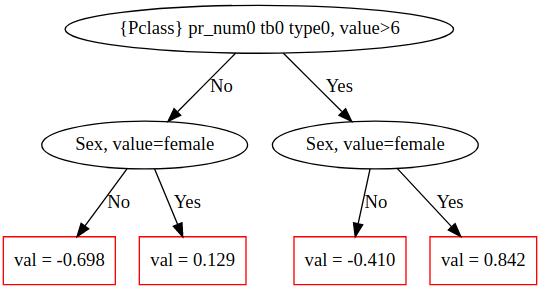!

In [ ]:
# Take a look at one of the internal trees.
loaded_model.plot_tree(tree_idx=0)

In [ ]:
# Testing: Get the 'probabilistic' predictions on the test data for the fold.
predictions = loaded_model.predict_proba(features_test)

In [ ]:
# Evaluation: Get the predicted class, i.e. the class with highest predicted probability.
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
labels_test

In [ ]:
predicted_classes

In [ ]:
# Create a new DF with just ID and timing info to hold the results.
result_df = data_df.iloc[test_indx][['Record', 'Label', 'Class']].copy().reset_index(drop=True)

# Add the predictive scores, labels and SHAP values to the result_df.      
result_df['Predicted_Label'] = predicted_classes

In [ ]:
result_df

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(result_df['Class'], result_df['Predicted_Label'], labels=loaded_model.classes_)  
print("[INFO:] Confusion Matrix:")
# Use the built in sklearn display for the confusion matrix.
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
conf_matrix_display.plot()
plt.show()

In [ ]:
# The samples where the predictions match the label.
result_df[result_df['Class']==result_df['Predicted_Label']]

In [ ]:
# The samples where the predictions DO NOT match the label.
result_df[result_df['Class']!=result_df['Predicted_Label']]

In [ ]:
# The samples that are predicted as normal but are labeled as AFib.
result_df[(result_df['Class']==1) & (result_df['Predicted_Label']==0)]

In [ ]:
# MIT Data

In [37]:
MIT_matching_table = pd.read_csv('afib_cohort_with_matching_waveform.csv')

In [38]:
MIT_matching_table

,subject_id,condition_date,concept_id,concept_name,record_id,waveform_start,waveform_end,waveform_path,time_diff
0,11740173,2172-11-09,4141360,Chronic atrial fibrillation,3677944,2172-11-09 12:38:23,2172-11-11 18:04:55.348327,36/3677944/3677944.hea,-1
1,13509520,2174-12-23,4232697,Persistent atrial fibrillation,3677580,2174-12-24 01:00:59,2174-12-25 15:06:04.810789,36/3677580/3677580.hea,-2
2,10267084,2147-11-30,313217,Atrial fibrillation,3524080,2147-11-30 21:22:42,2147-12-02 05:53:38.186970,35/3524080/3524080.hea,-1
3,11346699,2145-08-23,437894,Ventricular fibrillation,3334264,2145-08-31 22:15:28,2145-09-06 22:14:36.807428,33/3334264/3334264.hea,-9
4,13193330,2180-04-23,4154290,Paroxysmal atrial fibrillation,3935484,2180-04-24 20:58:31,2180-04-26 17:38:51.193693,39/3935484/3935484.hea,-2
...,...,...,...,...,...,...,...,...,...
608,10500792,2143-08-01,313217,Atrial fibrillation,3130169,2143-08-01 19:12:09,2143-08-02 16:40:46.112214,31/3130169/3130169.hea,-1
609,13506966,2176-10-14,313217,Atrial fibrillation,3852205,2176-10-22 19:49:34,2176-10-26 15:19:12.101489,38/3852205/3852205.hea,-9
610,10110863,2185-03-29,313217,Atrial fibrillation,3216361,2185-03-29 08:38:59,2185-03-29 20:46:19.947655,32/3216361/3216361.hea,-1
611,10042769,2156-07-24,313217,Atrial fibrillation,3585856,2156-07-28 05:53:50,2156-07-29 14:51:46.964943,35/3585856/3585856.hea,-5


In [39]:
# List all files in the directory
MIT_files = os.listdir('MIT_AFib_Dataset')

In [40]:
len(MIT_files)

603

In [41]:
# Extract the record IDs from the file names in the directory.
MIT_records = [int(record.split('_')[1]) for record in MIT_files if record.endswith('.csv')]

In [42]:
len(MIT_records)

603

In [43]:
# Filter the matching df to just the records that are in the directory.
MIT_matched_df = MIT_matching_table[MIT_matching_table['record_id'].isin(MIT_records)]

In [44]:
MIT_matched_df

,subject_id,condition_date,concept_id,concept_name,record_id,waveform_start,waveform_end,waveform_path,time_diff
0,11740173,2172-11-09,4141360,Chronic atrial fibrillation,3677944,2172-11-09 12:38:23,2172-11-11 18:04:55.348327,36/3677944/3677944.hea,-1
2,10267084,2147-11-30,313217,Atrial fibrillation,3524080,2147-11-30 21:22:42,2147-12-02 05:53:38.186970,35/3524080/3524080.hea,-1
3,11346699,2145-08-23,437894,Ventricular fibrillation,3334264,2145-08-31 22:15:28,2145-09-06 22:14:36.807428,33/3334264/3334264.hea,-9
4,13193330,2180-04-23,4154290,Paroxysmal atrial fibrillation,3935484,2180-04-24 20:58:31,2180-04-26 17:38:51.193693,39/3935484/3935484.hea,-2
5,11639762,2163-02-08,437894,Ventricular fibrillation,3612225,2163-02-08 12:47:58,2163-02-09 10:03:34.737634,36/3612225/3612225.hea,-1
...,...,...,...,...,...,...,...,...,...
608,10500792,2143-08-01,313217,Atrial fibrillation,3130169,2143-08-01 19:12:09,2143-08-02 16:40:46.112214,31/3130169/3130169.hea,-1
609,13506966,2176-10-14,313217,Atrial fibrillation,3852205,2176-10-22 19:49:34,2176-10-26 15:19:12.101489,38/3852205/3852205.hea,-9
610,10110863,2185-03-29,313217,Atrial fibrillation,3216361,2185-03-29 08:38:59,2185-03-29 20:46:19.947655,32/3216361/3216361.hea,-1
611,10042769,2156-07-24,313217,Atrial fibrillation,3585856,2156-07-28 05:53:50,2156-07-29 14:51:46.964943,35/3585856/3585856.hea,-5


In [ ]:
# Is one of the below bad and need to drop it?

In [45]:
MIT_matched_df[MIT_matched_df['time_diff']==-1]

,subject_id,condition_date,concept_id,concept_name,record_id,waveform_start,waveform_end,waveform_path,time_diff
0,11740173,2172-11-09,4141360,Chronic atrial fibrillation,3677944,2172-11-09 12:38:23,2172-11-11 18:04:55.348327,36/3677944/3677944.hea,-1
2,10267084,2147-11-30,313217,Atrial fibrillation,3524080,2147-11-30 21:22:42,2147-12-02 05:53:38.186970,35/3524080/3524080.hea,-1
5,11639762,2163-02-08,437894,Ventricular fibrillation,3612225,2163-02-08 12:47:58,2163-02-09 10:03:34.737634,36/3612225/3612225.hea,-1
10,13057021,2165-07-11,4154290,Paroxysmal atrial fibrillation,3042703,2165-07-11 22:28:50,2165-07-14 18:24:47.387546,30/3042703/3042703.hea,-1
23,10800948,2198-09-12,4154290,Paroxysmal atrial fibrillation,3776857,2198-09-12 08:21:58,2198-09-13 00:09:24.878502,37/3776857/3776857.hea,-1
...,...,...,...,...,...,...,...,...,...
606,11199826,2175-10-29,313217,Atrial fibrillation,3881270,2175-10-29 20:53:55,2175-11-02 19:28:38.432047,38/3881270/3881270.hea,-1
607,10864544,2114-07-01,313217,Atrial fibrillation,3934405,2114-07-01 23:15:19,2114-07-02 07:38:33.493357,39/3934405/3934405.hea,-1
608,10500792,2143-08-01,313217,Atrial fibrillation,3130169,2143-08-01 19:12:09,2143-08-02 16:40:46.112214,31/3130169/3130169.hea,-1
610,10110863,2185-03-29,313217,Atrial fibrillation,3216361,2185-03-29 08:38:59,2185-03-29 20:46:19.947655,32/3216361/3216361.hea,-1


In [46]:
# Lets take a look at the difference between the diagnosis time and the WF timestamps.
MIT_matched_df['time_diff'].value_counts()

time_diff
-1     153
-2      84
-3      24
-4      11
-6       7
-14      7
-7       5
 29      5
-15      4
-11      4
-9       4
-5       4
-17      4
 10      3
-23      3
 12      3
 8       3
 9       3
 11      3
-12      2
 17      2
-16      2
 21      2
-24      2
-19      2
 18      2
 15      2
 16      1
-22      1
-10      1
-18      1
-20      1
-26      1
 25      1
 22      1
-8       1
-27      1
 14      1
-28      1
 20      1
-29      1
 24      1
 23      1
 1       1
Name: count, dtype: int64

In [47]:
# Filter the matching table to records where the diagnosis is within a day of the WF data start.
MIT_matched_df = MIT_matched_df[MIT_matched_df['time_diff']==-1]

In [48]:
MIT_matched_df

,subject_id,condition_date,concept_id,concept_name,record_id,waveform_start,waveform_end,waveform_path,time_diff
0,11740173,2172-11-09,4141360,Chronic atrial fibrillation,3677944,2172-11-09 12:38:23,2172-11-11 18:04:55.348327,36/3677944/3677944.hea,-1
2,10267084,2147-11-30,313217,Atrial fibrillation,3524080,2147-11-30 21:22:42,2147-12-02 05:53:38.186970,35/3524080/3524080.hea,-1
5,11639762,2163-02-08,437894,Ventricular fibrillation,3612225,2163-02-08 12:47:58,2163-02-09 10:03:34.737634,36/3612225/3612225.hea,-1
10,13057021,2165-07-11,4154290,Paroxysmal atrial fibrillation,3042703,2165-07-11 22:28:50,2165-07-14 18:24:47.387546,30/3042703/3042703.hea,-1
23,10800948,2198-09-12,4154290,Paroxysmal atrial fibrillation,3776857,2198-09-12 08:21:58,2198-09-13 00:09:24.878502,37/3776857/3776857.hea,-1
...,...,...,...,...,...,...,...,...,...
606,11199826,2175-10-29,313217,Atrial fibrillation,3881270,2175-10-29 20:53:55,2175-11-02 19:28:38.432047,38/3881270/3881270.hea,-1
607,10864544,2114-07-01,313217,Atrial fibrillation,3934405,2114-07-01 23:15:19,2114-07-02 07:38:33.493357,39/3934405/3934405.hea,-1
608,10500792,2143-08-01,313217,Atrial fibrillation,3130169,2143-08-01 19:12:09,2143-08-02 16:40:46.112214,31/3130169/3130169.hea,-1
610,10110863,2185-03-29,313217,Atrial fibrillation,3216361,2185-03-29 08:38:59,2185-03-29 20:46:19.947655,32/3216361/3216361.hea,-1


In [49]:
MIT_matched_df['concept_name'].value_counts()

concept_name
Atrial fibrillation               133
Paroxysmal atrial fibrillation     10
Chronic atrial fibrillation         8
Ventricular fibrillation            2
Name: count, dtype: int64

In [50]:
target_id = MIT_matched_df['record_id'].iloc[0]

In [53]:
target_id

3677944

In [ ]:
# Do we need to add a bandpass filter, or does the DWT part of the preprocessing do enough?
data = bandpass_filter(data, sampling_frequency, passband=[0.1, 45.0])

In [ ]:
# Then can look at correct/incorrect prediction cases and plot the WF to see what we think.

In [ ]:
def load_MIT_predict(target_id):
    

In [51]:
# Get the corresponding label (all AFib).
lable = 1       

matching_file = None

for file_name in MIT_files:
    # Split the file name by underscores
    parts = file_name.split('_')
    # Extract the ID between the first and second underscores
    file_id = parts[1]
    # Check if the file ID matches the target ID
    if file_id == str(target_id):
        matching_file = file_name
        break

In [52]:
matching_file

'afib11740173_3677944_0006_II.csv'

In [54]:
# Load the WF data from record.
data = pd.read_csv(f'MIT_AFib_Dataset/{matching_file}', header=None)
samples = data.to_numpy()
data_array = np.squeeze(samples).astype(float)

In [ ]:
# Extract the features from the WF sample. Add the features and label to the relevant matrices.
MIT_features = feature_extraction(data_array, fs)

In [ ]:
# Create a pandas Series with feature names as index and corresponding values from numpy array as data
feature_series = pd.Series(MIT_features, index=feature_names)

# Convert the series to a DataFrame by transposing it
feature_df = feature_series.to_frame().T

selected_MIT_features = feature_df[selected_features]

# Testing: Get the 'probabilistic' predictions on the test data for the fold.
MIT_prediction = loaded_model.predict_proba(selected_MIT_features)

# Evaluation: Get the predicted class, i.e. the class with highest predicted probability.
MIT_predicted_class = np.argmax(MIT_prediction, axis=1)

In [ ]:
    return MIT_predicted_class

In [ ]:
MIT_predictions = []

for record_id in MIT_matched_df['record_id'].values:
    if record_id==3789101:
        continue
        
    print(f'Working on record: {record_id}')
    
    pred_class = load_MIT_predict(record_id)

    MIT_predictions.extend(pred_class)

In [ ]:
MIT_series = pd.Series(MIT_predictions)

In [ ]:
MIT_series.value_counts()

In [ ]:
# Put the predictions back into the DF

In [ ]:
# Look at correct/incorrect predictions with plots.

What's note been covered here:

Deep Learning 

SHAP for more in depth feature importance sample by sample.

<img src="https://www.researchgate.net/publication/375004703/figure/fig2/AS:11431281201500446@1698411617452/The-beeswarm-plot-proposed-by-SHAP-was-used-to-evaluate-the-importance-of-each-feature-of.ppm" alt="The beeswarm plot proposed by SHAP was used to evaluate the importance... |  Download Scientific Diagram"/>

The above SHAP 'Beeswarm' plot is from 'Explainable Machine-Learning Models for COVID-19 Prognosis Prediction Using Clinical, Laboratory and Radiomic Features' that uses telemetry and other factors to predict risk of SARS-CoV-2.